# Семинар 5: обработка звука

Первая часть семинара сделана на базе вводного семинара из курса по [DL в аудио, читаемого на ФКН.](https://github.com/XuMuK1/dla2023)

На этом семинаре мы поговорим про базовые способы работы с аудио, а также обучим нейронную сеть для автоматического распознавания речи (automatic speech recognition, ASR). Распознавать будем сказанные вслух цифры. Внутри нашего датасета будут числа от 0 до 999999, произнесенные на русском языке разными спикерами разного возраста и пола.

### План семинара:

1. Посмотрим на данные и вспомним все понятия с лекции.
2. Обработка данных
    - Создание датасета
    - Паддинг
    - Вычисление признаков
3. Пишем простенькую модель
4. Имплементируем метрику качества
5. Обучение модели

Для начала скачаем датасет и установим нужные библиотеки.

Скачайте архив `numbers.zip` по одной из ссылок ниже:
- https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P
- https://www.kaggle.com/datasets/fulyankin/russian-audiomnist

Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# скопируем данные в колаб
!cp /content/drive/MyDrive/data/numbers.zip /content/numbers.zip

In [3]:
# распакуем архив
!unzip -q numbers.zip -d data/

In [4]:
!pip install torchaudio
# !pip install torchaudio==0.12.1
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [5]:
import torchaudio
print(torchaudio.__version__)

2.2.1+cu121


In [6]:
import numpy as np
import pandas as pd

import os
from collections import defaultdict
from itertools import islice
from typing import Any

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.auto import trange

import matplotlib.pyplot as plt
from IPython import display

## 1. Данные

Подгрузим файл и вспомним все основные манипуляции над аудио.

In [7]:
wav, sr = torchaudio.load("data/numbers/test-example/209c6fb213.wav")

В переменной `sr` лежит [sample rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Sampling_rate) нашего файла. В переменной `wav` последовательность амлитуд звуковой волны.

In [8]:
sr

24000

In [9]:
wav

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
wav.min(), wav.max()

(tensor(-0.4805), tensor(0.4322))

In [11]:
wav.dtype

torch.float32

In [12]:
wav.shape

torch.Size([1, 82240])

Размер нашего файла `wav` -- `[1, 82240]`. Первая размерность это [число каналов](https://en.wikipedia.org/wiki/Multichannel_audio).

В аудио бывает несколько каналов. Например, разговоры с колл-центром обычно пишут под два уха. В левое говорит тот, кто звонит, в правое тот, кто отвечает.

In [13]:
def visualize_audio(wav: torch.Tensor, sr: int):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

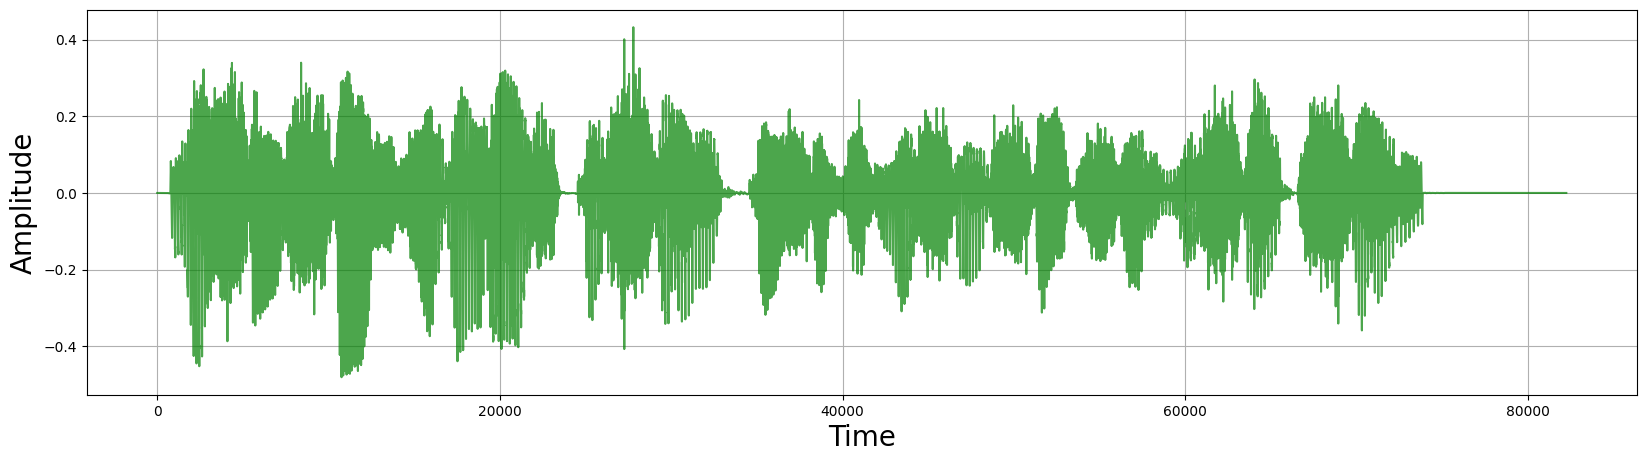

In [14]:
visualize_audio(wav, sr)

Взглянем на [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (Fast Fourier Transform).

Возьмём первые `1024` частот. С лекции мы помним, что спектр будет симметричным, можно отбросить половину чисел. Размерность у итогового тензора будет `n_fft // 2 + 1`.

In [15]:
n_fft = 1024
spectrum = torch.fft.rfft(wav, n=n_fft)
spectrum.shape

torch.Size([1, 513])

Все числа в спектре будут комплексными.

In [16]:
spectrum.dtype

torch.complex64

Построим [спектрограмму](https://en.wikipedia.org/wiki/Spectrogram). Для этого найдём модуль для каждого комплексного числа.

In [17]:
spectrogram = spectrum.abs().pow(2)

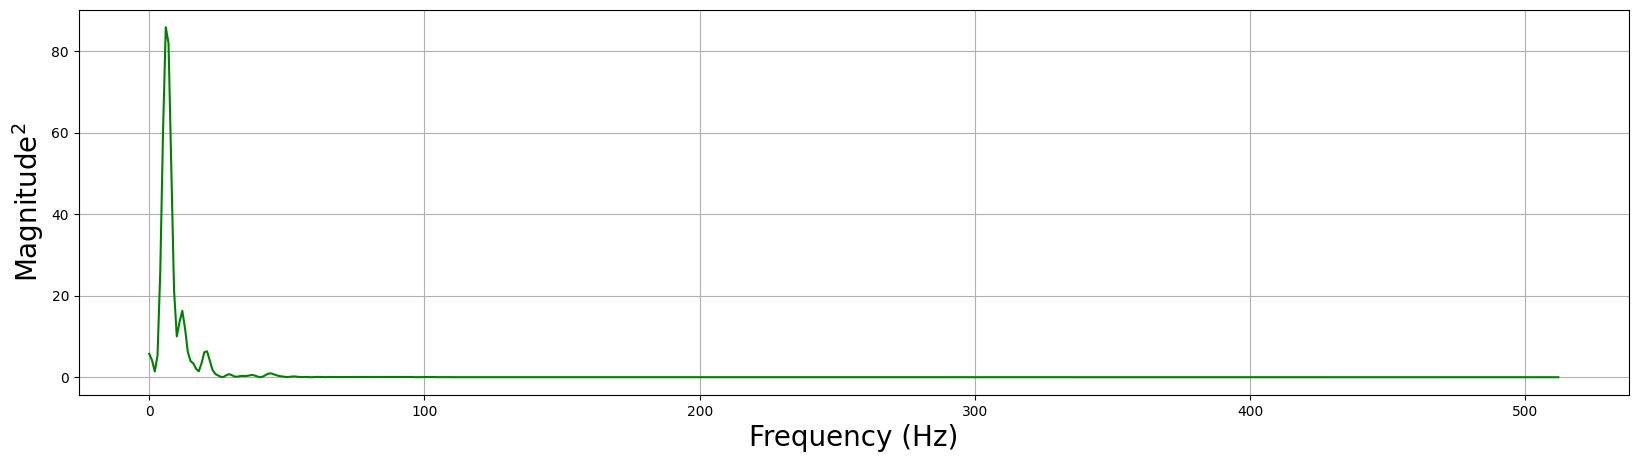

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()

Аудио длинное. Построив для него спектрограмму один раз мы потеряем очень много информации. Обычно по аудио проходятся оконной функцией и строят несколько спектрограмм. Это позволяет вычленить информацию о том, что происходит с частотами в каждой части аудио.

<center>
<img src="https://imgbly.com/ib/l7z3HBXtoj.png" height="550">
</center>

На каждое окошко будем предсказывать одну цифру. Понятно, что одна и та же цифра мб в нескольких окошках - мы просто уберем дубликаты. Чтобы отличать случаи, когда надо убрать дубликат, а когда в числе есть две идущие подряд одинаковые цифры, добавим в наш алфавит пустой символ (также и при молчании будет использоваться).

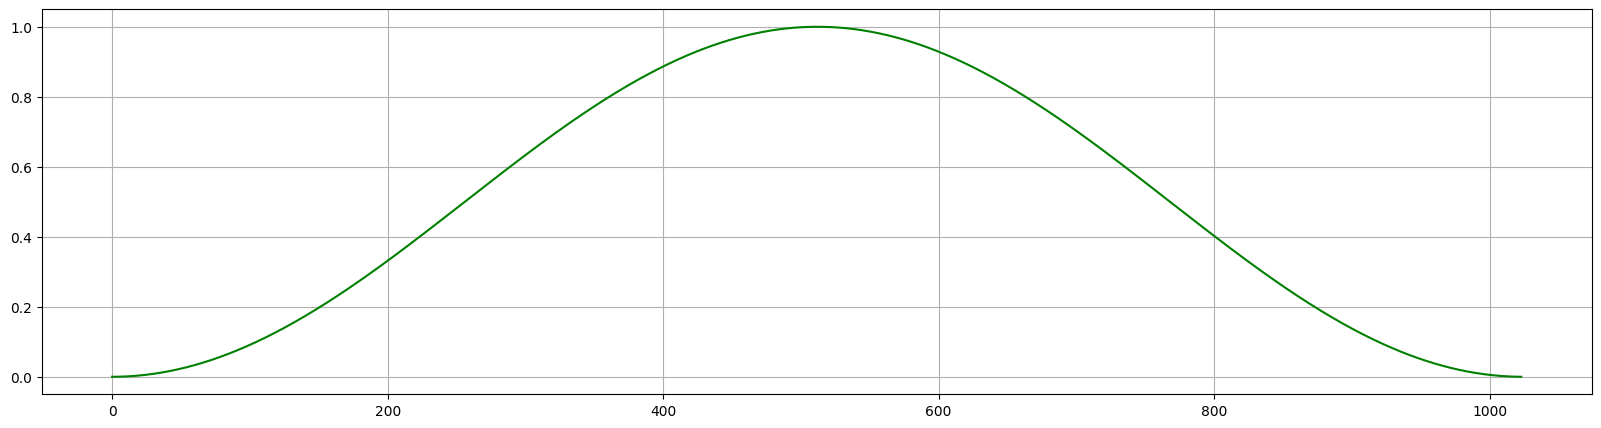

In [19]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()

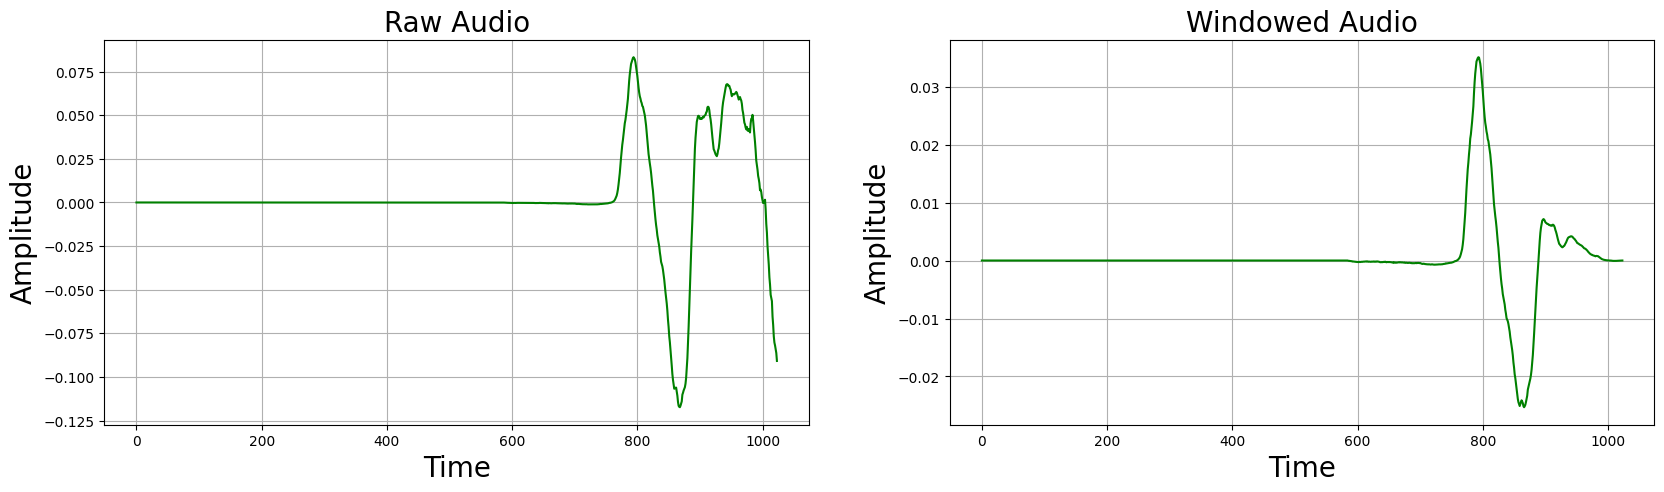

In [20]:
clipped_wav = wav[:, :window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()

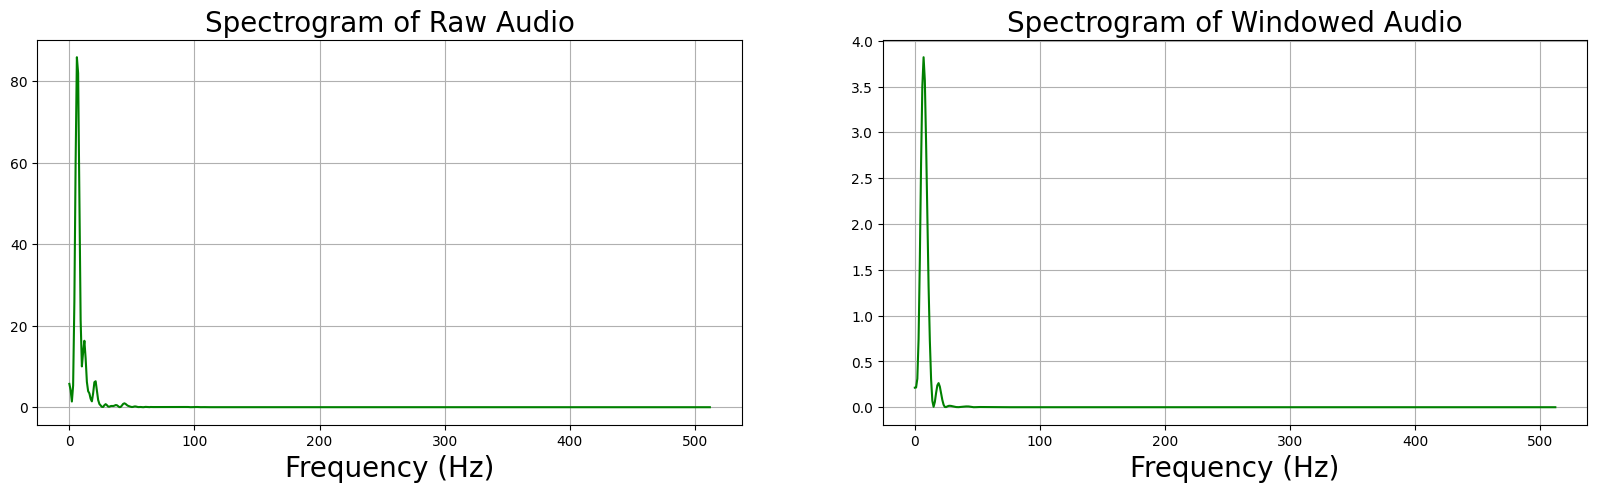

In [21]:
spectrogram = torch.fft.rfft(clipped_wav).abs().pow(2)
windowed_spectrogram = torch.fft.rfft(windowed_clipped_wav).abs().pow(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(spectrogram.squeeze(), c='green')
axes[0].set_title('Spectrogram of Raw Audio', size=20)

axes[1].plot(windowed_spectrogram.squeeze(), c='green')
axes[1].set_title('Spectrogram of Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Frequency (Hz)', size=20)

plt.show()

Соеденим всё вместе и получим [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (Short-time Fourier transform)

In [22]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(n_fft)

In [23]:
spectrum = torch.stft(
    wav,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,

    # We don't want to pad input signal
    center=False,

    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,

    # Apply torch.view_as_real on each window
    return_complex=False,
)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [24]:
spectrum.shape

torch.Size([1, 513, 318, 2])

In [25]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape

torch.Size([1, 513, 318])

Визуализируем спектрограмму. Чтобы перепады частот были более плавными, прологарифмируем все значения.

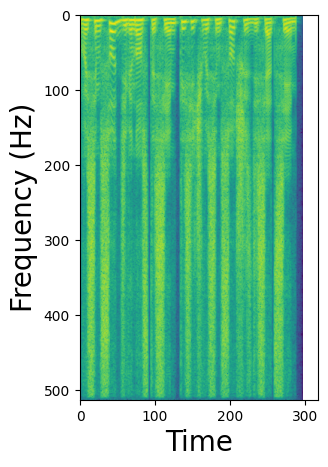

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

Последний шаг препроцессинга для человеческой речи это `Mel Scale`. Мы хотим отсеять неинформатиные высокие частоты, нетипичные для человеческой речи.

<center>
<img src="https://imgbly.com/ib/kwz2BzkvSj.png" height="400">
</center>




In [27]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=24000,
    n_stft=n_fft // 2 + 1
)

`Mel Scale` выглядит как треугольная матрица. Мы будем умножать каждую часть спекторограммы на неё.

In [28]:
mel_scaler.fb.shape

torch.Size([513, 80])

In [29]:
mel_scaler.fb.T

tensor([[-0.0000e+00, 9.1911e-01, 1.9125e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 8.0875e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0501e-01, 5.2507e-02,
         2.1877e-06]])

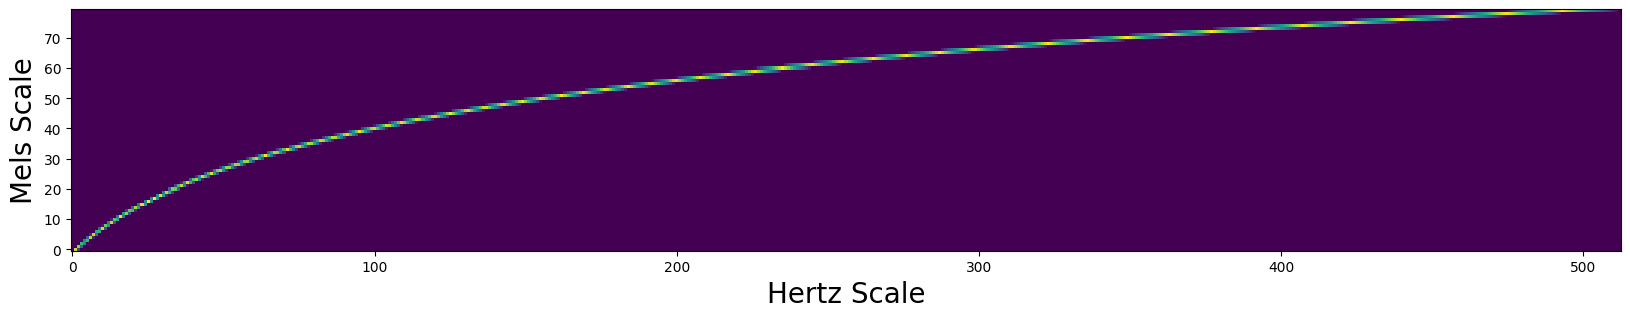

In [30]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel('Hertz Scale', size=20)
plt.ylabel('Mels Scale', size=20)
plt.gca().invert_yaxis()
plt.show()

In [31]:
mel_spectrogram = mel_scaler(spectrogram)

In [32]:
mel_spectrogram.shape

torch.Size([1, 80, 318])

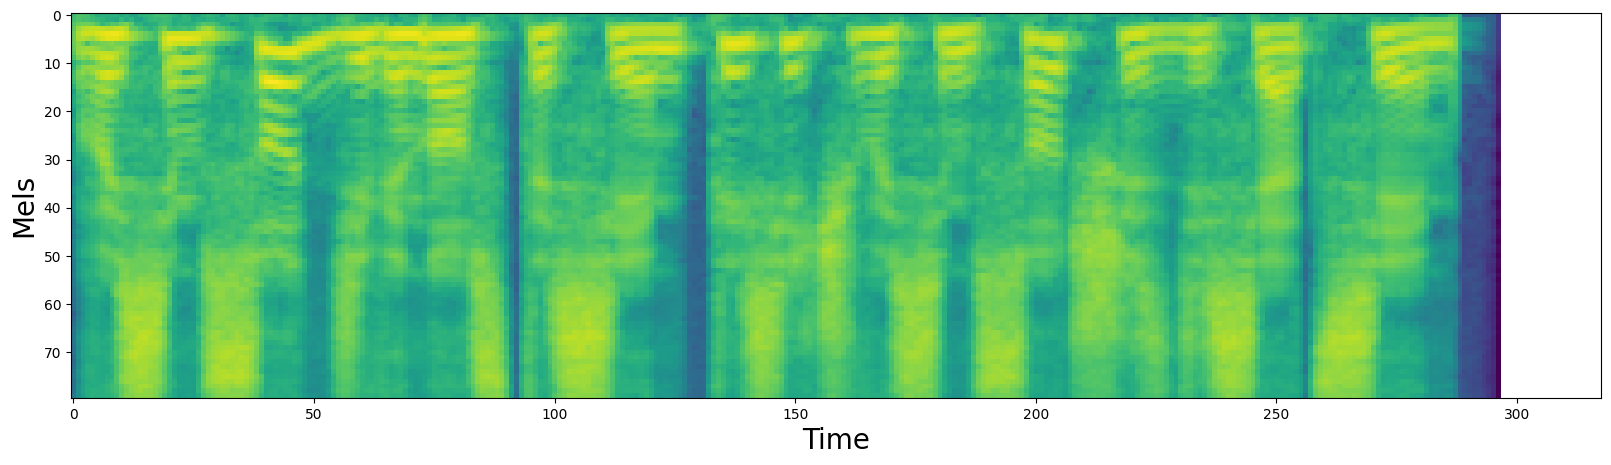

In [33]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

Все шаги, проделанные нами можно найти в классе `MelSpectrogram`. Он объединяет в себе оконный STFT, строительство спектрограммы и рпсчёт Mel.

In [34]:
featurizer = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
    window_fn=torch.hann_window,
    center=False
)

In [35]:
assert torch.allclose(mel_spectrogram, featurizer(wav))

## 2. Обработка данных

В целом, процесс преобразоания данных будет идти по такому пайплайну:

1. На вход получаем `.wav` аудиосигналы — одномерные векторы последовательности амлитуд звуковой волны (вейвформы).

2. По вейвформе мы проходимся окном фиксированного размера с фиксированным шагом и получаем набор аудиофреймов. Аудиофреймы обычно строят так, чтобы они довольно сильно пересекались.

3. Для каждого аудиофрейма вычисляем вклад различных частот (в виде вектора) при помощи [дискретного преобразования Фурье](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5#%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%87%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) (discrete Fourier transform, DFT), которое, в свою очередь, вычисляется при помощи алгоритма [быстрого преобразования Фурье](https://ru.wikipedia.org/wiki/%D0%91%D1%8B%D1%81%D1%82%D1%80%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5) (fast Fourier transform, FFT).

4. Композиция вкладов частот для каждого аудифрейма называется **спектрограммой**, которая является двумерной матрицей (по одной оси время, по второй — частоты).

5. Поскольку в спектрограмме обычно считают преобладание 8000 частот (бывает больше, бывает меньше), то она получается довольно большого размера, что трудоёмеко для вычислений (да и такая точность не очень нужна). Поэтому финальным шагом к ней применяют преобразование, чтобы получить [**мел спектрограмму**](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BB_(%D0%B2%D1%8B%D1%81%D0%BE%D1%82%D0%B0_%D0%B7%D0%B2%D1%83%D0%BA%D0%B0)) (mel scale). Мел спектрограмма обычно имеет вклад порядка 80 частот (получаются из предыдущих взвешенными суммами по бинам), которые имеют другой масштаб единиц измерения и больше подходят для описания голоса для человеческого слуха.

### 2.1 Создание датасета
Переведём все аудиозаписи к одинаковому `sample_rate=16000`, а ответы — к нужному нам виду. Например, если произносится число 123, то приводим ответ к виду `y = [1,2,3]`.

In [36]:
class SpeechDataset(Dataset):
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = "data/numbers"

    def __init__(self, path_to_csv: str) -> None:
        self.path_to_csv = path_to_csv
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int) -> dict[str, Any]:
        output = self.csv.iloc[index]

        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            (path,) = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)

        wav = wav.squeeze()
        instance = {"path": path, "x": wav, "y": y}
        return instance

    def __len__(self) -> int:
        return self.csv.shape[0]

In [37]:
dataset = SpeechDataset("data/numbers/train.csv")

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [38]:
len(train_dataset), len(val_dataset)

(8100, 900)

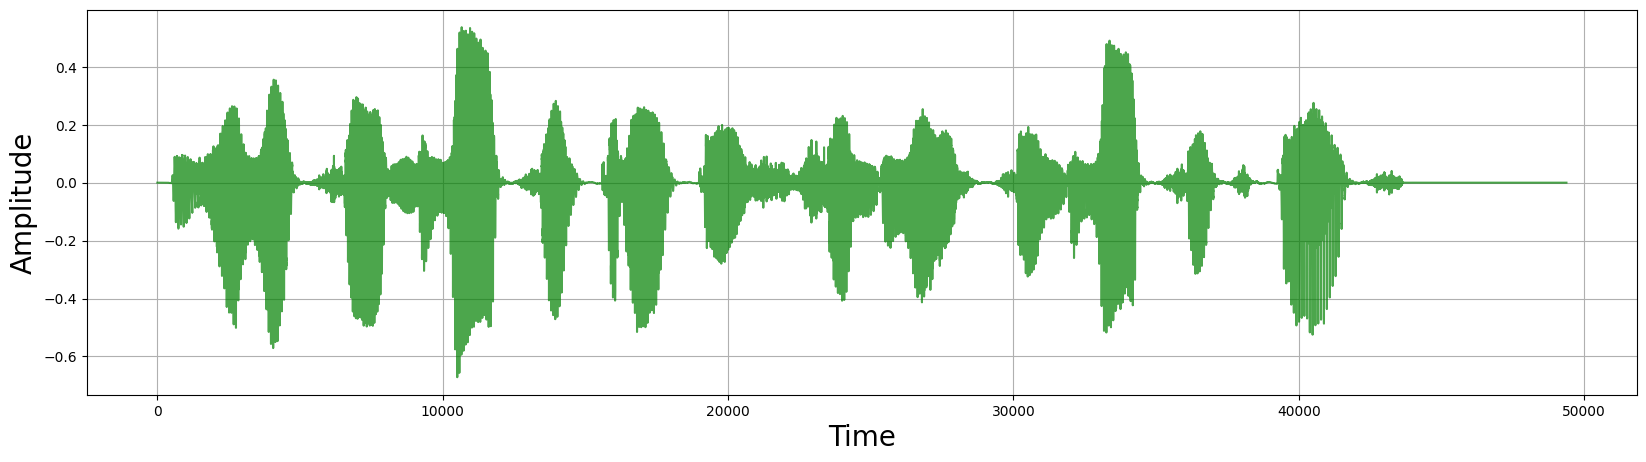

In [39]:
instance = train_dataset[0]
visualize_audio(instance["x"], dataset.SAMPLE_RATE)

In [40]:
instance["y"]

tensor([9, 2, 3, 2, 2, 5])

### 2.2 Паддинг

В датасете числа от 0 до 999999. Для упаковки батчей нам необходимо, чтобы все ответы $y$ были одинаковой длины. Если число короче шести знаков, то оставшиеся ячейки заполняем `10`:

```
123456 -> y = [1,2,3,4,5,6]
123    -> y = [1,2,3,10,10,10]
```

In [41]:
class PaddingCollator:
    def __call__(self, instances) -> dict[str, Any]:
        batch_size = len(instances)
        x_len = torch.LongTensor([instance["x"].size(0) for instance in instances])
        y_len = torch.LongTensor([instance["y"].size(0) for instance in instances])
        path = [instance["path"] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- паддинг

        for i, instance in enumerate(instances):
            x[i, : x_len[i]] = instance["x"]
            y[i, : y_len[i]] = instance["y"]

        instance = {"x": x, "y": y, "x_len": x_len, "y_len": y_len, "path": path}

        return instance

In [42]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    collate_fn=PaddingCollator(),
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=PaddingCollator(), pin_memory=True
)

In [43]:
batch = list(islice(val_dataloader, 1))[0]
batch

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y': tensor([[ 9,  6,  6,  9,  8,  0],
         [ 5,  9,  0,  8,  6,  4],
         [ 2,  8,  5,  1,  5,  8],
         [ 5,  3,  5,  8,  8,  8],
         [ 9,  9,  5,  4,  0,  1],
         [ 2,  5,  8,  4,  5,  8],
         [ 2,  4,  6,  5,  8,  5],
         [ 5,  8,  6,  6,  0,  8],
         [ 1,  7,  5,  8,  3,  4],
         [ 4,  0,  7,  1,  6,  4],
         [ 2,  1,  6,  4,  9,  4],
         [ 9,  9,  5,  8,  4,  2],
         [ 5,  0,  6,  4,  1, 10],
         [ 7,  5,  4,  7,  9,  6],
         [ 1,  5,  7,  6,  7,  8],
         [ 4,  0,  4,  7,  4,  2],
         [ 6,  5,  5,  8,  9,  8],
         [ 2,  2,  8,  5,  9,  1],
         [ 9,  3,  4,  1,  1, 10],
         [ 7,  5,  0,  2,  6,  9],
         [ 2,  6,  2,  9,  6

### 2.3 Вычисление признаков

**Идея**: нарезаем сигнал на кусочки, и для каждого кусочка делаем преобразование Фурье и вычисляем его мел-спектрограмму.
Подробнее:

- О преобразовании Фурье: https://proglib.io/p/fourier-transform/
- О параметрах мел-спектрограммы: https://rdrr.io/cran/torchaudio/man/transform_mel_spectrogram.html

<center>
<img src="https://imgbly.com/ib/l7z3HBXtoj.png" height="550">
</center>

In [44]:
instance = train_dataset[31]
wav = instance["x"]

In [45]:
from torchaudio.transforms import MelSpectrogram

featurizer = MelSpectrogram(
    sample_rate=train_dataset.dataset.SAMPLE_RATE,
    n_fft=512,
    win_length=512,
    hop_length=512,
    n_mels=64,
    power=1,
)

def apply_compression(melspec):
    # Добавляем eps=1e-7 чтобы избежать log(0)
    return torch.log(melspec.clamp(1e-5))

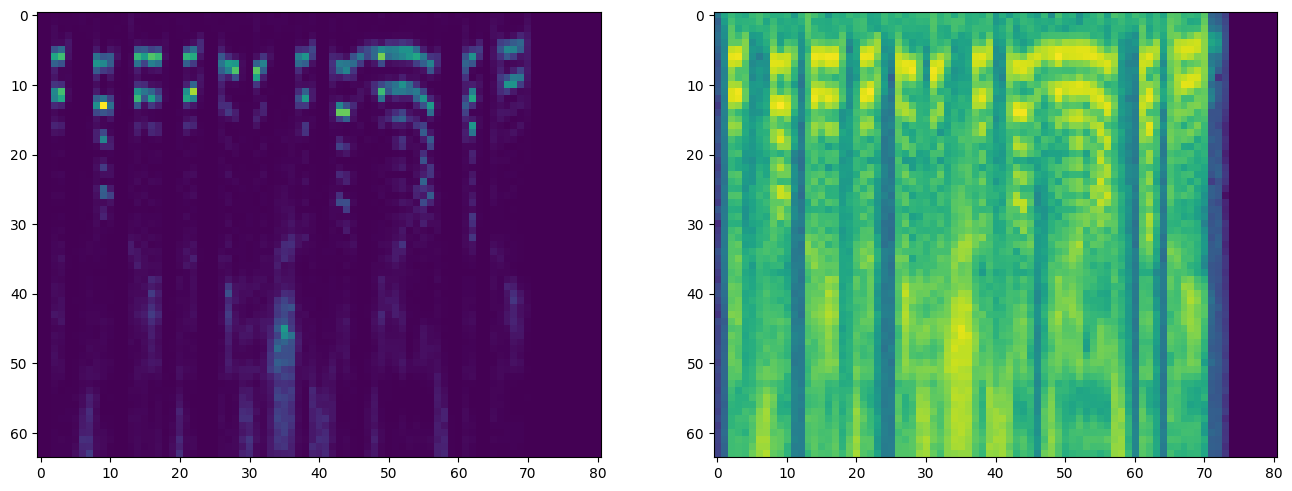

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(featurizer(wav))
axes[1].imshow(apply_compression(featurizer(wav)));

In [47]:
# Для того, чтобы работала аугментация на линукс надо доставить эту либу
# (а колаб работает на линуксе)
!sudo apt install libsox-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3
  libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
0 upgraded, 16 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,053 kB of archives.
After this operation, 4,061 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main

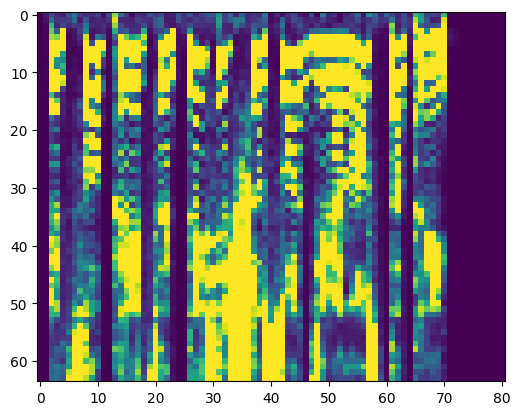

In [48]:
# Аугментация мел-спектрограммы
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]

waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    featurizer(wav).cpu(), 16000, effects, channels_first=True
)

plt.imshow(waveform);

In [49]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=512,
            win_length=512,
            hop_length=512,
            n_mels=64,
            power=1,
        )

    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)

        # Переводим длинну из wav размера в melSpec размер
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len

        return x

## 3. Пишем простенькую модель

Напишем простую и маленькую модель на основе [QuartzNet](https://arxiv.org/pdf/1910.10261.pdf).

In [50]:
class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times

    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ) -> None:
        super().__init__()

        self.repeat = repeat
        self.blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Conv1d(
                            in_channels=in_channels if i == 0 else hidden_channels,
                            out_channels=hidden_channels,
                            kernel_size=kernel_size,
                            groups=in_channels if i == 0 else hidden_channels,
                            padding=kernel_size // 2,
                            bias=False,
                        ),
                        nn.Conv1d(
                            hidden_channels, hidden_channels, kernel_size=1, bias=False
                        ),
                        nn.BatchNorm1d(hidden_channels),
                        nn.ReLU(),
                        nn.Dropout(p=0.2, inplace=False),
                    ]
                )
                for i in range(repeat)
            ]
        )
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_initial = x

        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j == (len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x

In [51]:
class DummyModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels) -> None:
        super().__init__()

        self.prenet = nn.Sequential(
            nn.Conv1d(
                in_channels, hidden_channels, 33, padding=33 // 2, stride=2, bias=False
            ),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
        )

        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),
            nn.Conv1d(
                hidden_channels * 2,
                hidden_channels * 2,
                33,
                padding=33 // 2,
                stride=2,
                bias=False,
            ),
            nn.Conv1d(
                hidden_channels * 2, hidden_channels * 2, kernel_size=1, bias=False
            ),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            QuartzBlock(hidden_channels * 2, hidden_channels * 4),
        )

        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1, bias=False),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x: torch.Tensor, x_len: int) -> tuple[torch.Tensor, int]:
        x = self.prenet(x)
        x = self.net(x)

        return self.classifier(x), x_len // 4

## 4. Имплементируем метрику качества

В качестве метрики качества будем использовать [CER (character error rate)](https://huggingface.co/spaces/evaluate-metric/cer). По сути это доля неверно угаданных символов в ответе. Если смотреть чуть подробнее, то это расстояние Левенштейна между предсказанием и рефернсом (таргетом, ground truth), поделённое на длину референса. По [ссылке](https://www.rev.ai/blog/how-to-calculate-word-error-rate/) можете посмотреть на пример вычисления аналогичной метрики, но по словам (WER, word error rate).

<center>
<img src="https://imgbly.com/ib/uRsXtQ7aBq.png" height="350">
</center>

Для вычисления CTC-loss необходимо сделать предобработку предсказния: убрать повторяющиеся символы и blank-символы.

<center>
<img src="https://imgbly.com/ib/xGYZMTxWoM.png" height="250">
</center>


In [52]:
import Levenshtein

def ctc_decode(sequence, black_symbol=10):
    """
    Декодируем гипотезы
        1) Убираем повторяющиеся буквы
        2) Удаляем blank символы
    """
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = "".join(current)
    return text

def calculate_cer(targets, decodings, padding_value=10):
    """
    Считаем расстояние Левенштейна между предсказаниями и GT
    """

    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(target + "\t\t" + decoding)

    return cer / len(targets), pairs

## 4. Обучение

In [53]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [54]:
NUM_EPOCH = 20
DEVICE = torch.device("cuda:0")

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [55]:
history = defaultdict(list)

In [ ]:
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]

for epoch in trange(NUM_EPOCH):
    average_cer = AverageMeter()
    average_loss = AverageMeter()

    for batch in train_dataloader:
        x = batch["x"].to(DEVICE)
        y = batch["y"].to(DEVICE)
        x_len = batch["x_len"].to(DEVICE)
        y_len = batch["y_len"].to(DEVICE)

        x, x_len = mel_featurizer(x, x_len)

        # здесь можно добавить аугментацию

        batch_size = x.shape[2]
        for i in range(batch_size // 2):
            if i % 2 == 0:
                # аугментация из torchaudio
                tmp, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
                    x[:, :, i].cpu(), 16000, effects
                )
                x[:, :, i] = tmp.to(DEVICE)

        log_probs, x_len = model(x, x_len)

        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history["loss"].append(average_loss.avg)
        history["cer"].append(average_cer.avg)

    display.clear_output()
    print(f"Epoch: {epoch}")
    for i in range(5):
        print(f"Example of prediction: ", pairs[i].replace("\t\t", " -> "))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history["loss"], label="Loss")
    axes[1].plot(history["cer"], label="CER")
    axes[0].legend()
    axes[0].grid()
    axes[1].legend()
    axes[1].grid()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

## Что делать дальше?

1. Добавить аугментацию! Например, аугментация [SpecAug](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/).
2. Улучшить модель. Например, еще больше уменьшить временное пространство. Сейчас мы его уменьшаем в 4 раза, но это все равно мало так как длина GT строк 4-6.
3. Перевести цифры в буквы и учить распознавание на буквах.
4. Добавить спец символ, которым разделяем разряды: тысячи/сотни.
5. Stack more layers :)